In [34]:
import os
import re
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt

class Stitcher():
    def __init__(self, initial_config_path = 'stitcher_config.yaml'):
        
        with open(initial_config_path, "r") as file:
            initial_config = yaml.safe_load(file)
        
        # General configuration
        self.input_dir = initial_config["input_dir"]
        self.output_dir = initial_config["output_dir"]
        self.feature_detector_algo = initial_config.get("feature_detector_algo", "SIFT")
        self.matcher_type = initial_config.get("matcher_type", "BF")
        self.plot = initial_config.get("plot", False)
        self.input_images = []

        # Hyperparameters
        self.ratio_test_threshold = initial_config.get("ratio_test_threshold", 0.5)
        self.ransac_threshold = initial_config.get("ransac_threshold", 5.0)

        # SIFT-specific parameters
        sift_config = initial_config.get("sift", {})
        self.sift_nfeatures = sift_config.get("nfeatures", 0)
        self.sift_nOctaveLayers = sift_config.get("nOctaveLayers", 3)
        self.sift_contrastThreshold = sift_config.get("contrastThreshold", 0.04)
        self.sift_edgeThreshold = sift_config.get("edgeThreshold", 10)
        self.sift_sigma = sift_config.get("sigma", 1.6)

        # ORB-specific parameters
        orb_config = initial_config.get("orb", {})
        self.orb_nfeatures = orb_config.get("nfeatures", 2000)
        self.orb_scaleFactor = orb_config.get("scaleFactor", 1.2)
        self.orb_nlevels = orb_config.get("nlevels", 8)
        self.orb_edgeThreshold = orb_config.get("edgeThreshold", 31)
        self.orb_firstLevel = orb_config.get("firstLevel", 0)
        self.orb_WTA_K = orb_config.get("WTA_K", 2)
        
        self.orb_scoreType = (cv2.ORB_HARRIS_SCORE 
                              if orb_config.get("scoreType") == "ORB_HARRIS_SCORE" 
                              else cv2.ORB_FAST_SCORE)
        
        self.orb_patchSize = orb_config.get("patchSize", 31)
        self.orb_fastThreshold = orb_config.get("fastThreshold", 20)

        

    def read_input_dir(self, right_to_left=False):
        image_extensions = {".jpeg", ".jpg", ".png"}
        
        # Filter and sort files by numeric prefix
        files = [f for f in os.listdir(self.input_dir) if os.path.splitext(f)[1].lower() in image_extensions]
        files.sort(key=lambda f: int(re.match(r'(\d+)', f).group()))
        if right_to_left:
            files = files[::-1]
        
        for file in files:
            img = cv2.imread(os.path.join(self.input_dir, file))
            if img is not None:
                self.input_images.append(img)
            else:
                print(f"Could not read image {file} in {self.input_dir}")
        
        if len(self.input_images) < 2:
            raise ValueError("Not enough images in the input directory.")
        else:
            print(f"Found {len(self.input_images)} images in the input directory.")
            
    
    ## FEATURE DETECTION AND DESCRIPTION
            
    def detect_keypoints_and_descriptors(self, custom_input_image = None):
        
        # Initialize the specified Feature Detector
        if self.feature_detector_algo == "SIFT":
            self.feature_detector = cv2.SIFT_create(
                nfeatures=self.sift_nfeatures,
                nOctaveLayers=self.sift_nOctaveLayers,
                contrastThreshold=self.sift_contrastThreshold,
                edgeThreshold=self.sift_edgeThreshold,
                sigma=self.sift_sigma
            )
        elif self.feature_detector_algo == "ORB":
            self.feature_detector = cv2.ORB_create(
                nfeatures=self.orb_nfeatures,
                scaleFactor=self.orb_scaleFactor,
                nlevels=self.orb_nlevels,
                edgeThreshold=self.orb_edgeThreshold,
                firstLevel=self.orb_firstLevel,
                WTA_K=self.orb_WTA_K,
                scoreType=self.orb_scoreType,
                patchSize=self.orb_patchSize,
                fastThreshold=self.orb_fastThreshold
            )
        else:
            raise ValueError("Invalid feature detector. Use 'SIFT' or 'ORB'.")
        
        if custom_input_image is not None:
            img = custom_input_image
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = self.feature_detector.detectAndCompute(gray, None)
            
            print(f"Detected {len(keypoints)} keypoints in image using {self.feature_detector_algo}.")
            
            if self.plot:
                self.plot_features(img, keypoints, title=f"Keypoints in Image")
            
            return keypoints, descriptors
                    
        
        # Detect keypoints and compute descriptors for each image in the specified input folder
        self.feature_points_and_descriptors = []
        
        for i, img in enumerate(self.input_images):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = self.feature_detector.detectAndCompute(gray, None)
            
            if keypoints is not None and descriptors is not None:
                self.feature_points_and_descriptors.append((keypoints, descriptors))
                print(f"Detected {len(keypoints)} keypoints in image {i+1} using {self.feature_detector_algo}.")
                
                if self.plot:
                    self.plot_features(img, keypoints, title=f"Keypoints in Image {i+1}")
            else:
                print(f"Failed to detect keypoints in image {i+1}")
                
        print("Feature detection completed.")
        
    
    def plot_features(self, img, keypoints, title="Detected Keypoints"):
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()
        
    def sift_vs_orb(self, img, default=False):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Initialize SIFT with current configuration
        sift = cv2.SIFT_create(
            nfeatures=self.sift_nfeatures,
            nOctaveLayers=self.sift_nOctaveLayers,
            contrastThreshold=self.sift_contrastThreshold,
            edgeThreshold=self.sift_edgeThreshold,
            sigma=self.sift_sigma
        )
        if default:
            sift = cv2.SIFT_create()
        
        # Detect SIFT keypoints and descriptors
        sift_keypoints, _ = sift.detectAndCompute(gray, None)
        img_sift = cv2.drawKeypoints(img, sift_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Initialize ORB with current configuration
        orb = cv2.ORB_create(
            nfeatures=self.orb_nfeatures,
            scaleFactor=self.orb_scaleFactor,
            nlevels=self.orb_nlevels,
            edgeThreshold=self.orb_edgeThreshold,
            firstLevel=self.orb_firstLevel,
            WTA_K=self.orb_WTA_K,
            scoreType=self.orb_scoreType,
            patchSize=self.orb_patchSize,
            fastThreshold=self.orb_fastThreshold
        )
        if default:
            orb = cv2.ORB_create()
        
        # Detect ORB keypoints and descriptors
        orb_keypoints, _ = orb.detectAndCompute(gray, None)
        img_orb = cv2.drawKeypoints(img, orb_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Plot side-by-side comparison
        plt.figure(figsize=(18, 12))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
        plt.title("SIFT Keypoints")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_orb, cv2.COLOR_BGR2RGB))
        plt.title("ORB Keypoints")
        plt.axis('off')
        
        plt.show()
        
        print(f"Detected {len(sift_keypoints)} SIFT keypoints and {len(orb_keypoints)} ORB keypoints.")
        
    def sift_vs_orb_features(self, default=False):
        for i, img in enumerate(self.input_images):
            self.sift_vs_orb(img, default=default)
    
    def print_feature_detector_config(self):
        print(f"Current Feature Detector: {self.feature_detector_algo}")
        print(f"\nSIFT Configuration: \n"
                f"nfeatures:\t\t {self.sift_nfeatures}\n",
                f"nOctaveLayers:\t\t {self.sift_nOctaveLayers}\n",
                f"contrastThreshold:\t {self.sift_contrastThreshold}\n",
                f"edgeThreshold:\t\t {self.sift_edgeThreshold}\n",
                f"sigma:\t\t\t {self.sift_sigma}\n")
        
        print(f"ORB Configuration: \n",
                f"nfeatures:\t\t {self.orb_nfeatures}\n",
                f"scaleFactor:\t\t {self.orb_scaleFactor}\n",
                f"nlevels:\t\t {self.orb_nlevels}\n",
                f"edgeThreshold:\t\t {self.orb_edgeThreshold}\n",
                f"firstLevel:\t\t {self.orb_firstLevel}\n",
                f"WTA_K:\t\t\t {self.orb_WTA_K}\n",
                f"scoreType:\t\t {self.orb_scoreType}\n",
                f"patchSize:\t\t {self.orb_patchSize}\n",
                f"fastThreshold:\t\t {self.orb_fastThreshold}\n")
    
    
    ## FEATURE MATCHING 
    
    def match_features(self, descriptors1, descriptors2):
        
        # Initialize matcher
        if self.matcher_type == "BF":
            norm_type = cv2.NORM_L2 if self.feature_detector_algo == "SIFT" else cv2.NORM_HAMMING
            self.matcher = cv2.BFMatcher(norm_type, crossCheck=False)
        elif self.matcher_type == "FLANN":
            index_params = dict(algorithm=1, trees=5)
            search_params = dict(checks=50)
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
        else:
            raise ValueError("Invalid matcher type. Use 'BF' or 'FLANN'.")
        
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)
        return matches
    
    def ratio_test(self, matches):
        good_matches = [m for m, n in matches if m.distance < self.ratio_test_threshold * n.distance]
        return good_matches

    def ransac_homography(self, kp1, kp2, good_matches):
        points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, mask = cv2.findHomography(points2, points1, cv2.RANSAC, self.ransac_threshold)
        
        inliers = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
        
        return H, inliers

    def plot_matches(self, img1, img2, kp1, kp2, matches):
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title("Feature Matches")
        plt.axis("off")
        plt.show()
        
        print(f"Found {len(matches)} matches.")

    def match_two_images(self, img1, img2, kp1, des1, kp2, des2, ransac = True):
        good_matches = self.match_features(des1, des2)
        good_matches = self.ratio_test(good_matches)
        
        if self.plot:
            self.plot_matches(img1, img2, kp1, kp2, good_matches)
        
        
        if ransac:
            H, inliers = self.ransac_homography(kp1, kp2, good_matches)
            
            if H is None:
                print("ERROR: Failed to find homography matrix.")
            elif self.plot:
                self.plot_matches(img1, img2, kp1, kp2, inliers)
            
            print(f"Found {len(inliers)} inliers after RANSAC.")
    
    def see_all_matches(self, ransac=True):
        for i in range(len(self.input_images) - 1):
            img1 = self.input_images[i]
            img2 = self.input_images[i + 1]
            kp1, des1 = self.feature_points_and_descriptors[i]
            kp2, des2 = self.feature_points_and_descriptors[i + 1]
            self.match_two_images(img1, img2, kp1, des1, kp2, des2, ransac=False)
            
              

    ## IMAGE ALIGNMENT AND STITCHING
    
    
    # def warp_and_stitch(self, img1, img2, H):
    #     # Get dimensions of the images
    #     h1, w1 = img1.shape[:2]
    #     h2, w2 = img2.shape[:2]
        
    #     # Find the corners of img2 after warping
    #     corners_img2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    #     warped_corners_img2 = cv2.perspectiveTransform(corners_img2, H)
        
    #     # Find the dimensions of the resulting stitched image
    #     corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    #     all_corners = np.concatenate((warped_corners_img2, corners_img1), axis=0)
        
    #     # Calculate the bounding box of the stitched image
    #     [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    #     [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
        
    #     # Translation matrix to shift the warped image into the visible area of the canvas
    #     translation_dist = [-x_min, -y_min]
    #     translation_matrix = np.array([[1, 0, translation_dist[0]], 
    #                                    [0, 1, translation_dist[1]], 
    #                                    [0, 0, 1]])
        
    #     # Warp img2 using the homography matrix and translation matrix
    #     result_img = cv2.warpPerspective(img2, translation_matrix @ H, (x_max - x_min, y_max - y_min))
        
    #     # Paste img1 onto the canvas
    #     result_img[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = img1
        
    #     if self.plot:
    #         plt.figure(figsize=(15, 10))
    #         plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    #         plt.title("Warped and Stitched Image")
    #         plt.axis("off")
    #         plt.show()
        
    #     return result_img
    
    def warp_and_stitch(self, base_img, warp_img, H, backward_warp=True):
        # Get dimensions of the images
        h1, w1 = base_img.shape[:2]
        h2, w2 = warp_img.shape[:2]

        # Define corners of the images for warping
        corners_warp_img = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        corners_base_img = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

        # Apply forward or backward warping based on the parameter
        if backward_warp:
            warped_corners = cv2.perspectiveTransform(corners_base_img, np.linalg.inv(H))
            all_corners = np.concatenate((warped_corners, corners_warp_img), axis=0)
        else:
            warped_corners = cv2.perspectiveTransform(corners_warp_img, H)
            all_corners = np.concatenate((warped_corners, corners_base_img), axis=0)

        # Calculate the bounding box of the stitched image
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

        # Calculate the translation matrix
        translation_dist = [-x_min, -y_min]
        translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

        # Apply the appropriate warping method
        if backward_warp:
            result_img = cv2.warpPerspective(base_img, translation_matrix @ np.linalg.inv(H), (x_max - x_min, y_max - y_min))
            result_img[translation_dist[1]:h2 + translation_dist[1], translation_dist[0]:w2 + translation_dist[0]] = warp_img
        else:
            result_img = cv2.warpPerspective(warp_img, translation_matrix @ H, (x_max - x_min, y_max - y_min))
            result_img[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = base_img

        if self.plot:
            plt.figure(figsize=(15, 10))
            plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
            plt.title("Warped and Stitched Image")
            plt.axis("off")
            plt.show()

        return result_img


    def stitch_all_images(self):
        # Ensure we have keypoints and descriptors for all images
        if not hasattr(self, 'feature_points_and_descriptors'):
            raise ValueError("Feature points and descriptors are missing. Run detect_keypoints_and_descriptors() first.")
        
        # Start with the first image
        stitched_img = self.input_images[0]

        # Iterate over consecutive pairs of images
        for i in range(len(self.input_images) - 1):
            img1 = stitched_img
            img2 = self.input_images[i + 1]
            kp1, des1 = self.feature_points_and_descriptors[i]
            kp2, des2 = self.feature_points_and_descriptors[i + 1]
            
            # Step 1: Match features
            matches = self.match_features(des1, des2)
            
            # Step 2: Apply the ratio test
            good_matches = self.ratio_test(matches)
            
            # Step 3: Calculate homography using RANSAC
            H, inliers = self.ransac_homography(kp1, kp2, good_matches)
            
            # Step 4: Warp and stitch the images
            stitched_img = self.warp_and_stitch(img1, img2, H)
        
        # Return the final stitched image
        
        if self.plot:
            plt.figure(figsize=(18, 18))
            plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
            plt.title("Stitched Image")
            plt.axis("off")
            plt.show()
        return stitched_img
    
    def stitch_consecutive_images(self):
        # Ensure we have keypoints and descriptors for all images
        if not hasattr(self, 'feature_points_and_descriptors'):
            raise ValueError("Feature points and descriptors are missing. Run detect_keypoints_and_descriptors() first.")
        
        # Start with the first image
        stitched_img = self.input_images[0]

        # Iterate over consecutive pairs of images
        for i in range(len(self.input_images) - 1):
            img1 = self.input_images[i]
            img2 = self.input_images[i + 1]
            kp1, des1 = self.feature_points_and_descriptors[i]
            kp2, des2 = self.feature_points_and_descriptors[i + 1]
            
            # Step 1: Match features
            matches = self.match_features(des1, des2)
            
            # Step 2: Apply the ratio test
            good_matches = self.ratio_test(matches)
            
            # Step 3: Calculate homography using RANSAC
            H, inliers = self.ransac_homography(kp1, kp2, good_matches)
            
            # Step 4: Warp and stitch the images
            stitched_img = self.warp_and_stitch(img1, img2, H)
        
        # Return the final stitched image
        
        if self.plot:
            plt.figure(figsize=(18, 18))
            plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
            plt.title("Stitched Image")
            plt.axis("off")
            plt.show()
        return stitched_img
    
    def stitch3(self):
        if len(self.input_images) != 3:
            raise ValueError("stitch3 method requires exactly 3 input images.")

        # Extract images
        img1 = self.input_images[0]
        img2 = self.input_images[1]
        img3 = self.input_images[2]

        # Extract keypoints and descriptors
        kp1, des1 = self.feature_points_and_descriptors[0]
        kp2, des2 = self.feature_points_and_descriptors[1]
        kp3, des3 = self.feature_points_and_descriptors[2]

        # Step 1: Match features between img1 and img2, and img3 and img2
        matches12 = self.match_features(des1, des2)
        good_matches12 = self.ratio_test(matches12)
        matches32 = self.match_features(des3, des2)
        good_matches32 = self.ratio_test(matches32)

        # Step 2: Calculate homographies using RANSAC
        H12, inliers12 = self.ransac_homography(kp1, kp2, good_matches12)
        H32, inliers32 = self.ransac_homography(kp3, kp2, good_matches32)

        # Step 3: Warp img1 and img3 to align with img2
        warped_img1 = self.warp_and_stitch(img1, img2, H12, backward_warp=True)  # warp img1 to img2
        warped_img3 = self.warp_and_stitch(img3, img2, H32, backward_warp=True)  # warp img3 to img2

        # Step 4: Stitch warped_img1 and warped_img3
        kp_warped1, des_warped1 = self.detect_keypoints_and_descriptors(custom_input_image=warped_img1)
        kp_warped3, des_warped3 = self.detect_keypoints_and_descriptors(custom_input_image=warped_img3)

        matches_warped = self.match_features(des_warped1, des_warped3)
        good_matches_warped = self.ratio_test(matches_warped)
        H_warped, inliers_warped = self.ransac_homography(kp_warped1, kp_warped3, good_matches_warped)

        stitched_image = self.warp_and_stitch(warped_img1, warped_img3, H_warped)

        # Display and save the final stitched image
        if self.plot:
            plt.figure(figsize=(18, 18))
            plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
            plt.title("Stitched Image")
            plt.axis("off")
            plt.show()
            
        cv2.imwrite(os.path.join(self.output_dir, "stitched_image.jpg"), stitched_image)
        
        return stitched_image

    

    



In [35]:
# Creating a Stitcher object with initial specifications
stitcher = Stitcher()
stitcher.read_input_dir(right_to_left=True)

Found 3 images in the input directory.


In [36]:
stitcher.orb_nfeatures = 5000
stitcher.sift_nfeatures = 5000

- Based on insights from the above analysis, and the requirements of the downstream tasks, we can choose the feature detector and descriptor that best suits our needs.

Detected 4955 keypoints in image 1 using ORB.


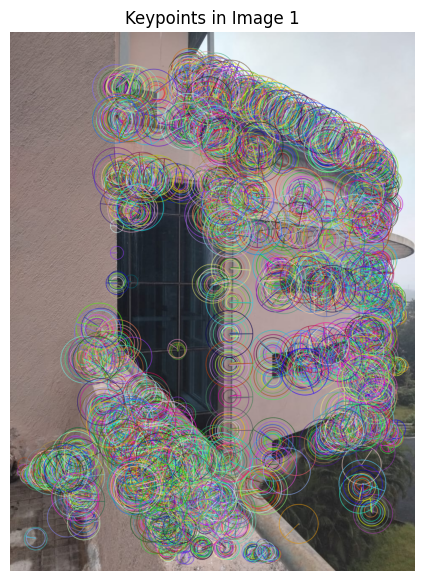

Detected 4556 keypoints in image 2 using ORB.


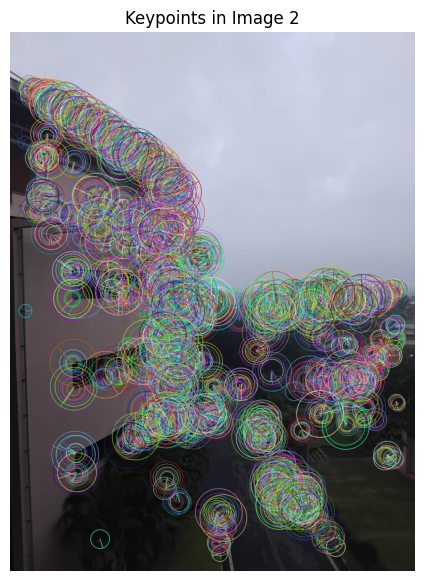

Detected 4842 keypoints in image 3 using ORB.


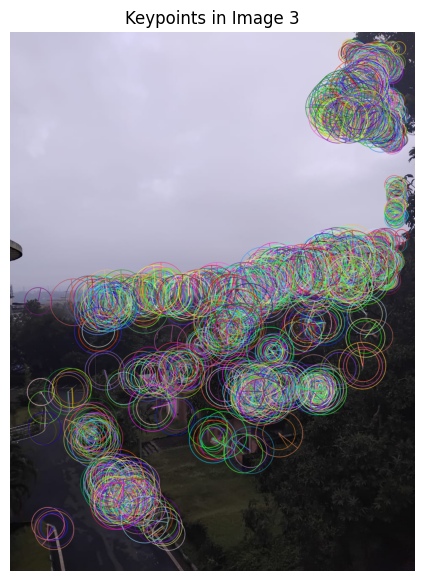

Feature detection completed.


In [37]:
stitcher.feature_detector_algo = "ORB"
stitcher.detect_keypoints_and_descriptors()

In [38]:
stitcher.ratio_test_threshold = 0.5
stitcher.ransac_threshold = 0.3
# stitcher.see_all_matches(ransac=True)

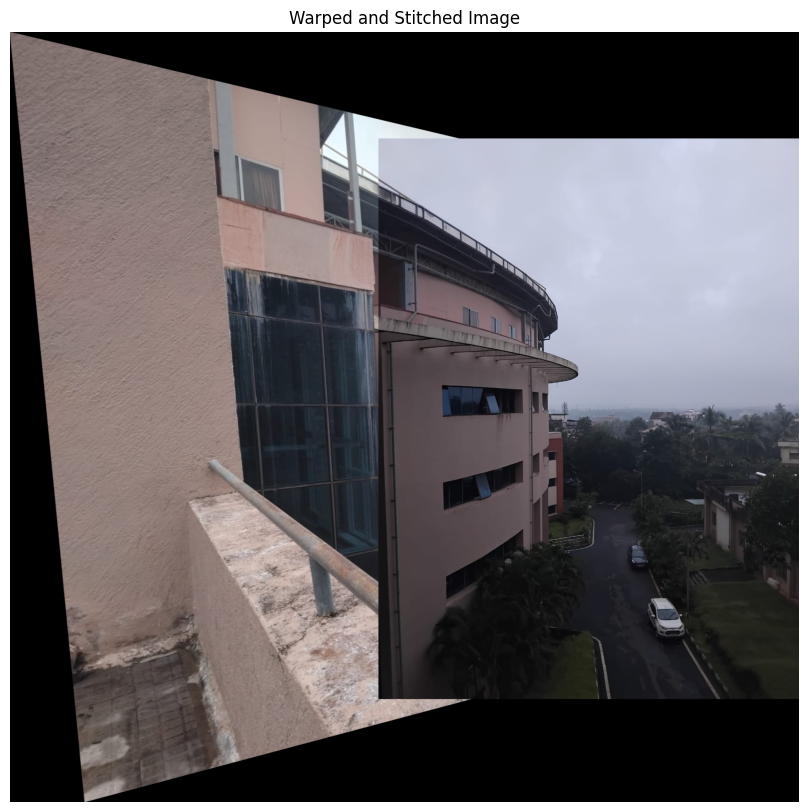

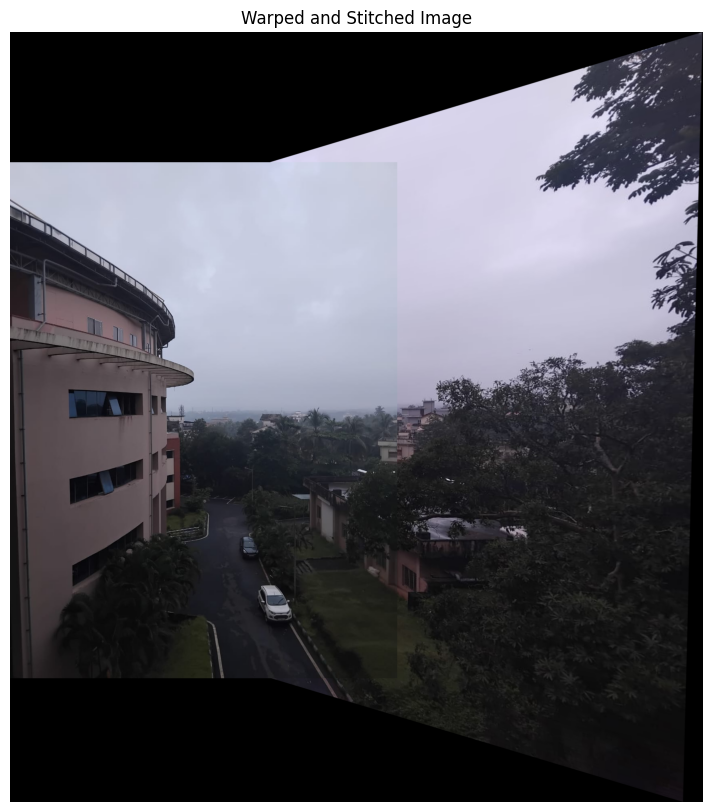

Detected 5000 keypoints in image using ORB.


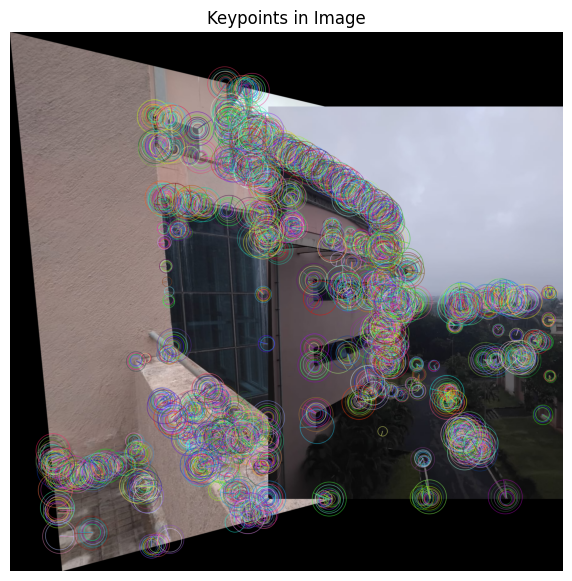

Detected 5000 keypoints in image using ORB.


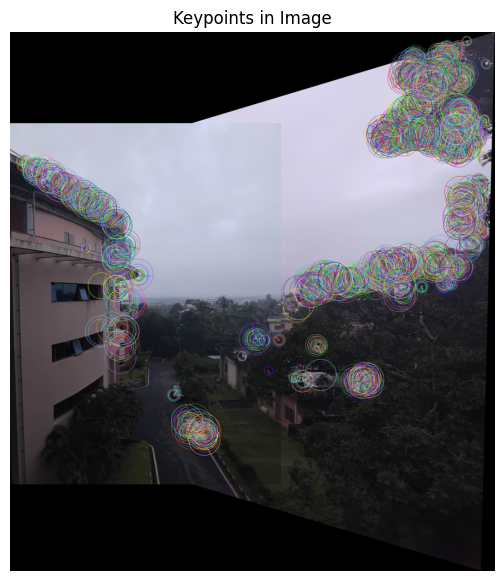

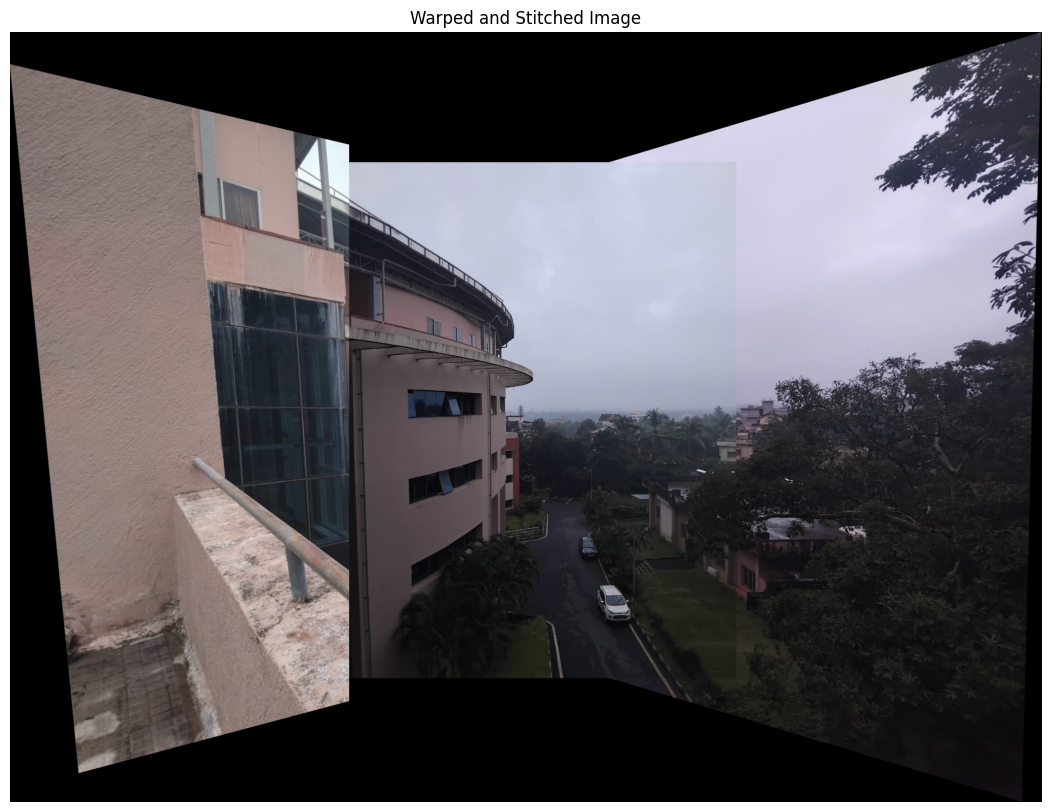

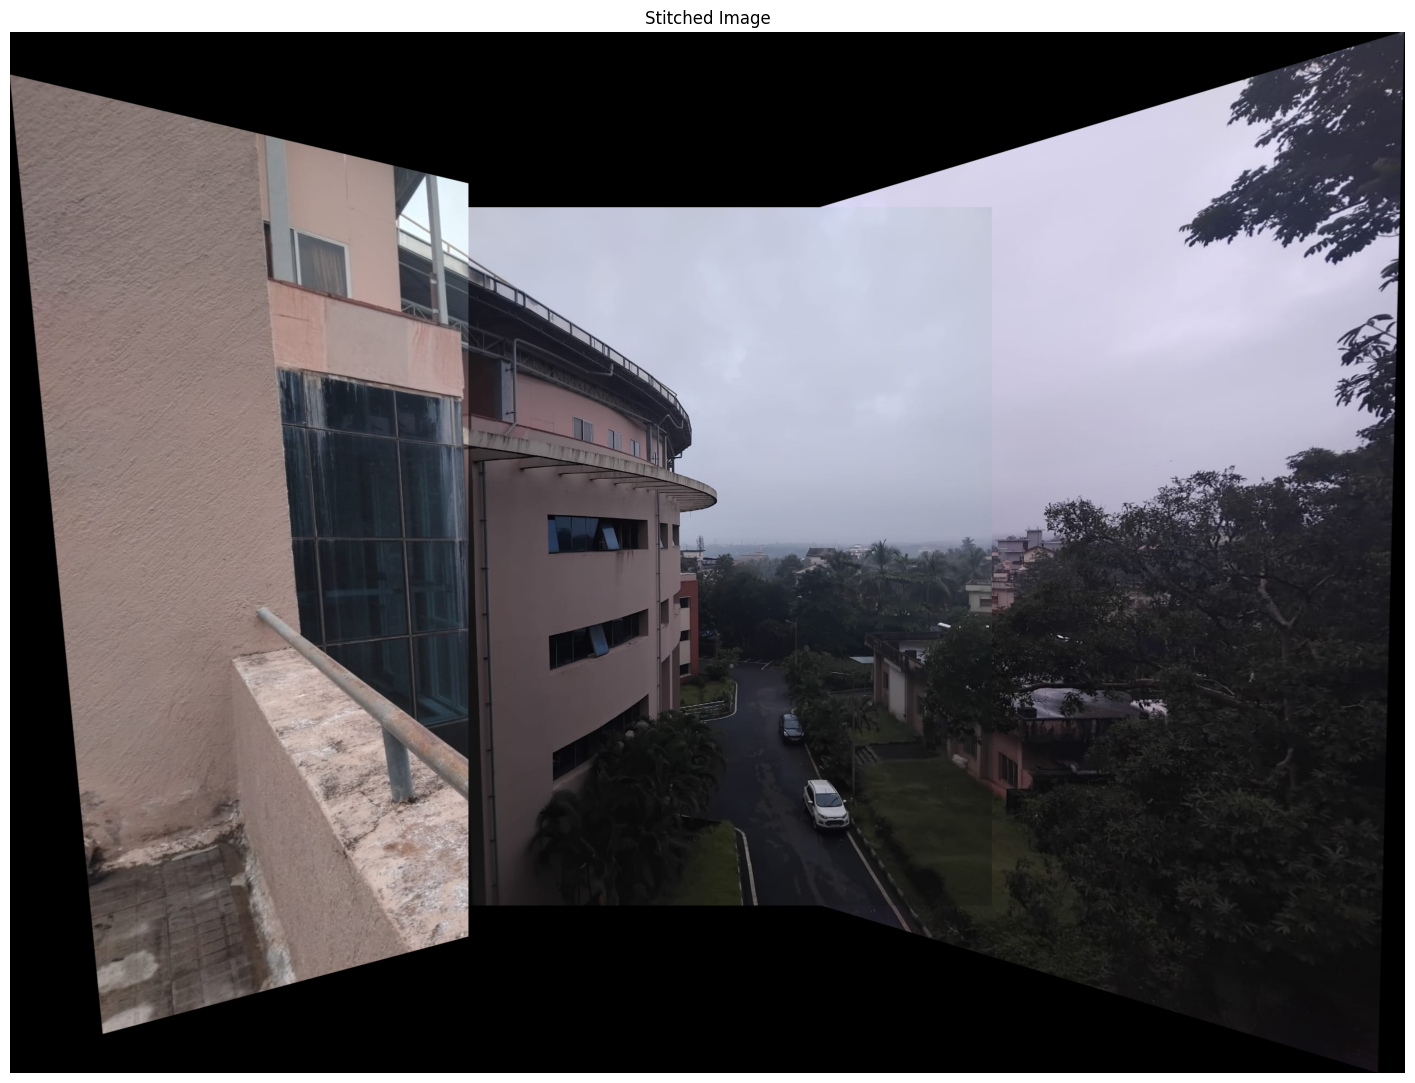

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [29, 23, 23],
        [27, 22, 22],
        [14, 11, 11]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [70, 56, 57],
        [45, 36, 36],
        [14, 11, 11]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [67, 53, 54],
        [42, 32, 33],
        [14, 11, 11]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [39]:
stitcher.stitch3()